<a href="https://colab.research.google.com/github/sanjeetarya001/TimeSeriesDatasets/blob/main/wavelets_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Preprocessing

In [ ]:
"""Gas Prices Data Processing"""
import pandas as pd
import pywt
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime

import math
import scipy as sp
import sklearn
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings("ignore")

In [ ]:
path = 'https://github.com/sanjeetarya001/TimeSeriesdata/raw/main/gas_price.csv'
GasPrices = pd.read_csv(path)
GasPrices.columns = ['Week', 'Price']

In [ ]:
GasPrices

,Week,Price
0,01/10/1997,3.79
1,01/17/1997,4.19
2,01/24/1997,2.98
3,01/31/1997,2.91
4,02/07/1997,2.53
...,...,...
1371,04/28/2023,2.20
1372,05/05/2023,2.03
1373,05/12/2023,2.10
1374,05/19/2023,2.29


In [ ]:
#Want data from January 2000 to November 2013

#Find the indices of each
GasPrices['Week'][GasPrices['Week'] == "01/07/2000"].index

Int64Index([156], dtype='int64')

In [ ]:
GasPrices['Week'][GasPrices['Week'] == "11/29/2013"].index

Int64Index([880], dtype='int64')

In [ ]:
data = GasPrices[156:881]
data.set_index(['Week'], inplace = True)
#data_ts = data.reindex(index = data.index[::-1])
data.index = pd.to_datetime(data.index, format = '%m/%d/%Y')

In [ ]:
data

,Price
Week,
2000-01-07,2.18
2000-01-14,2.25
2000-01-21,2.46
2000-01-28,2.71
2000-02-04,2.81
...,...
2013-11-01,3.55
2013-11-08,3.47
2013-11-15,3.62


Text(0, 0.5, 'Dollars per Million Btu')

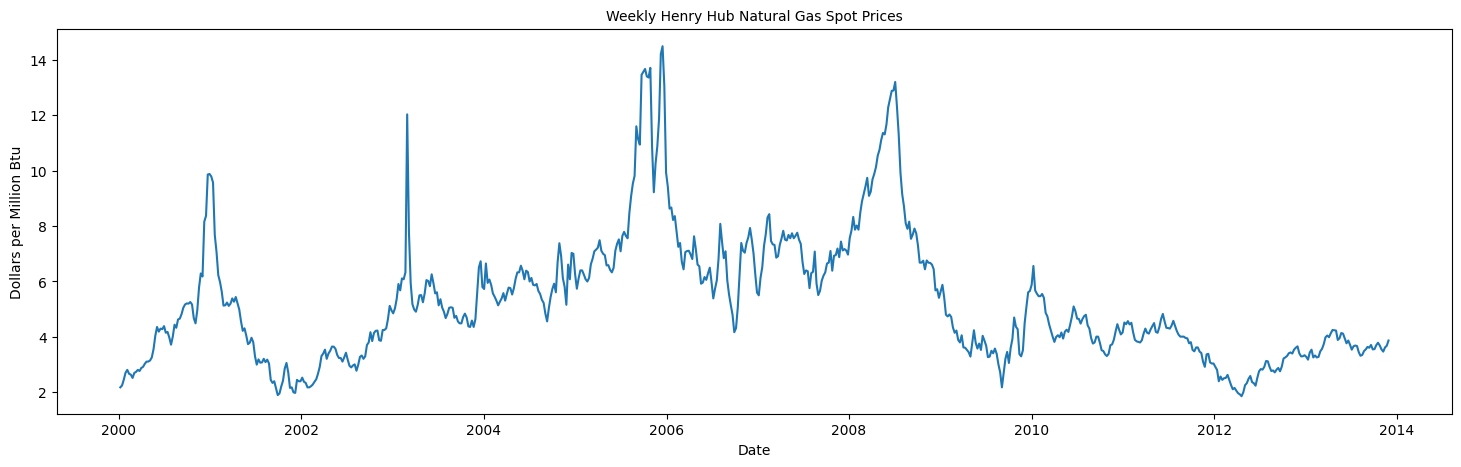

In [ ]:
plt.figure(100, figsize=(18, 5))
plt.plot(data)
###################################plt.plot(test_ts)
plt.title('Weekly Henry Hub Natural Gas Spot Prices', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Dollars per Million Btu', fontsize=10)

In [ ]:
#Use first 624 observations to build models
data_ts = data[0:624]
#Use the last 101 observations to test forecasting performance
test_ts = data[624:]

In [ ]:
#Reshape
data_ts_np = data_ts.to_numpy()
print(data_ts_np.shape)
data_ts1 = data_ts_np.reshape((len(data_ts_np,)))
print(data_ts_np.shape)
test_ts_np = test_ts.to_numpy()
print(test_ts_np.shape)
test_ts1 = test_ts_np.reshape((len(test_ts_np,)))
print(test_ts_np.shape)

(624, 1)
(624, 1)
(101, 1)
(101, 1)


##Neural Network code



In [ ]:
"""Neural Network code to clean up other scripts that depend on it"""

def NeuralNet_ts_predictions(train_data, test_data, num_lags, hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08):

    import sklearn
    from sklearn.neural_network import MLPRegressor
    from sklearn import preprocessing

    #Create data frame to shift
    train_data_df = pd.DataFrame(train_data)
    test_data_df = pd.DataFrame(test_data)

    #Get features from lagged time series
    train_data_np = np.zeros((len(train_data),num_lags+1))
    train_data_df_combined = pd.DataFrame(train_data_np)
    train_data_df_combined.iloc[:,0] = train_data_df
    test_data_np = np.zeros((len(test_data),num_lags+1))
    test_data_df_combined = pd.DataFrame(test_data_np)
    test_data_df_combined.iloc[:,0] = test_data_df

    for i in range(1, num_lags+1):
        train_data_df_combined.iloc[:,i] = train_data_df.shift(-i)
        test_data_df_combined.iloc[:,i] = test_data_df.shift(-i)

    #Drop rows with NANs
    train_data_combined_clean = train_data_df_combined.dropna()
    test_data_combined_clean = test_data_df_combined.dropna()

    #Standardize the input data
    train_data_combined_standardized = preprocessing.scale(train_data_combined_clean)
    test_data_combined_standardized = preprocessing.scale(test_data_combined_clean)

    #Target variable
    train_target = train_data_combined_standardized[:,-1]
    test_target = test_data_combined_standardized[:,-1]

    #Build the network model
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, batch_size=batch_size, learning_rate=learning_rate, learning_rate_init=learning_rate_init, power_t=power_t, max_iter=max_iter, shuffle=shuffle, random_state=random_state, tol=tol, verbose=verbose, warm_start=warm_start, momentum=momentum, nesterovs_momentum=nesterovs_momentum, early_stopping=early_stopping, validation_fraction=validation_fraction, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

    #Fit the model to the training data
    mlp.fit(train_data_combined_standardized[:,:-1], train_target)

    #Predictions
    preds = mlp.predict(test_data_combined_standardized[:,:-1])

    #Evaluations of standardized predictions
    MSE_std = ((preds - test_target)**2).mean()
    RMSE_std = math.sqrt(MSE_std)
    print(MSE_std, RMSE_std, mlp.score(test_data_combined_standardized[:,:-1], test_target))

    #De-standardize predictions
    preds_unstd = preds * test_data_combined_clean.iloc[:,-1].std() + test_data_combined_clean.iloc[:,-1].mean()

    #Evaluations of unstandardized predictions
    MSE = ((preds_unstd - test_data_combined_clean.iloc[:,-1])**2).mean()
    RMSE = math.sqrt(MSE)
    print(MSE, RMSE)

    return preds, preds_unstd, MSE_std, RMSE_std, MSE, RMSE


##Error Evaluation Functions

In [ ]:
"""Error Evaluation Functions"""
def MSE(forecasts, original):
    import math

    #Mean-Squared Error
    error = forecasts - original
    error_sq = error**2
    mse = error_sq.mean()

    #Root-Mean-Squared Error
    rmse = math.sqrt(mse)

    print("MSE is: ", mse)
    print("RMSE is: ", rmse)

    return mse, rmse

def MAPE(forecasts, original):

    #Mean Absolute Percentage Error
    ape = abs((forecasts - original)/original)
    mape = ape.mean()

    print("MAPE is: ", mape)

    return mape



## ANN

In [ ]:
"""ANN-N/A-N/A"""
MSE_arr = []
order = []

for j in range(1,11):
    preds_orig, preds_unstd_orig, MSE_std, RMSE_std, MSE, RMSE = NeuralNet_ts_predictions(data_ts1, test_ts1, num_lags=3, hidden_layer_sizes=(j,), activation='relu', random_state=42, solver='adam', max_iter=1000, tol=1e-10)
    MSE_arr = MSE_arr + [MSE]
    order = order + [j]
    #print(min(MSE_arr), MSE_arr.index(min(MSE_arr)), order[MSE_arr.index(min(MSE_arr))])

print(MSE_arr)
print(order)
#Minimum MSE when num_lags = 6 (i=6) and number of neurons in the hidden layer = 2 (j=2)
#MSE = 0.0471347462999
#RMSE = 0.21710538063319457

#According to paper, need 3 lags, 3 neurons in 1 hidden layer
preds_orig, preds_unstd_orig, MSE_std, RMSE_std, MSE, RMSE = NeuralNet_ts_predictions(data_ts1, test_ts1, num_lags=3, hidden_layer_sizes=(3,), random_state=42, solver='lbfgs', max_iter=1000, tol=1e-20)

MAPE_orig = (abs(preds_unstd_orig-np.ravel(data[627:725]))/np.ravel(data[627:725])).sum()/len(preds_unstd_orig)
print(MAPE_orig)
#MAPE = 0.0368642736914


0.19237627202510313 0.43860719559202754 0.807623727974897
0.07296920755189051 0.27012813172990796
0.10060566862090028 0.31718396652558006 0.8993943313790997
0.03777349598466857 0.19435404802748146
0.08648619671150896 0.29408535616638404 0.9135138032884911
0.03266031847437988 0.18072166022472205
0.05848430423256081 0.24183528326644319 0.9415156957674392
0.022246487647818804 0.14915256500583154
0.05183830617878197 0.2276802718260455 0.9481616938212181
0.01964792935036444 0.1401710717315254
0.05634928401902582 0.23738004132408821 0.9436507159809742
0.021494471963021487 0.14660993132465988
0.05372558961225516 0.23178781161280926 0.9462744103877448
0.02037940683608644 0.14275645987515395
0.055631170351314 0.2358626090572942 0.9443688296486861
0.021116543937333473 0.14531532588592805
0.0554726023437607 0.23552622432281442 0.9445273976562394
0.02101172215429239 0.1449542070941454
0.06068292035246347 0.24633903538104446 0.9393170796475365
0.023116474033961942 0.15204102746943648
[0.07296920755

##ARIMA

In [ ]:
"""ARIMA-N/A-N/A"""
import statsmodels.api as sm
arima_orig_train_mod = sm.tsa.statespace.SARIMAX(data[0:624],order=(0,1,1))
arima_orig_train_res = arima_orig_train_mod.fit(maxiter=100)

arima_orig = sm.tsa.SARIMAX(data, order=(0,1,1))
arima_orig_res = arima_orig.filter(arima_orig_train_res.params)

arima_orig_preds = arima_orig_res.predict(start=624,end=724)

MSE_arima_orig = ((arima_orig_preds[3:]-np.ravel(data[627:725]))**2).mean()
RMSE_arima_orig = math.sqrt(MSE_arima_orig)
MAPE_arima_orig = (abs(arima_orig_preds[3:]-np.ravel(data[627:725]))/np.ravel(data[627:725])).sum()/len(arima_orig_preds[3:])
print(MSE_arima_orig, RMSE_arima_orig, MAPE_arima_orig)
#MSE = 0.019654105103565883
#RMSE = 0.14019309934360494
#MAPE = 0.037738759706018046

0.01965414237054179 0.14019323225656005 0.037738821144944604


Text(0, 0.5, 'Dollars per Million Btu')

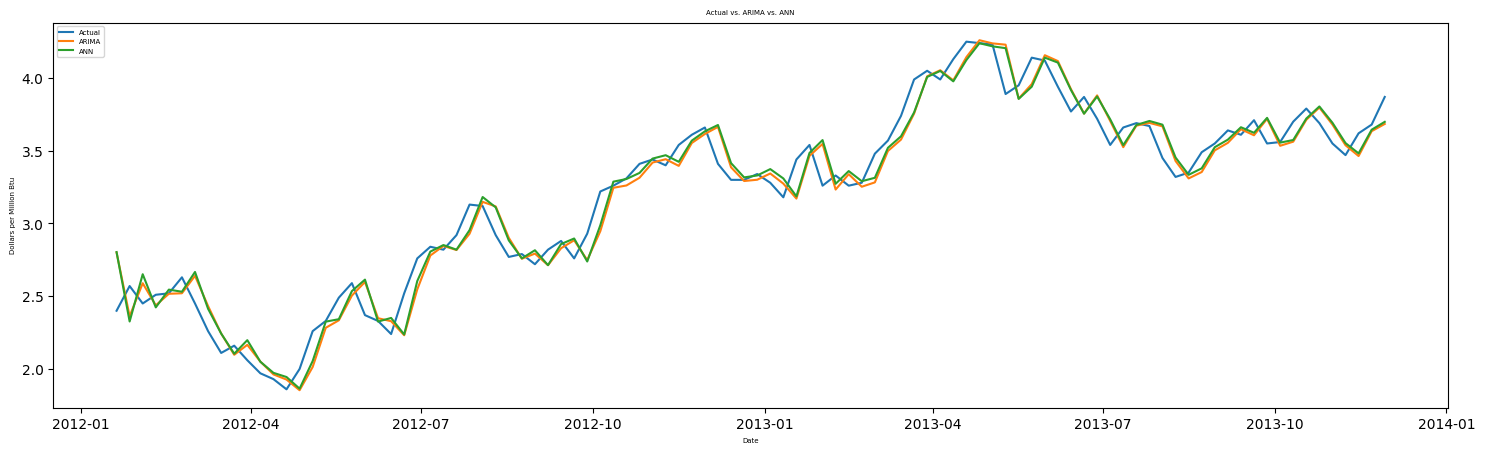

In [ ]:
"""Plot"""
plt.figure(100, figsize=(18, 5))
preds_unstd_orig_df = pd.DataFrame(preds_unstd_orig, index=data[627:725].index)
plt.plot(data[627:725], label='Actual')
plt.plot(arima_orig_preds[3:], label='ARIMA')
plt.plot(preds_unstd_orig_df, label='ANN')
plt.legend(loc='upper left', prop={'size':5})
plt.title('Actual vs. ARIMA vs. ANN', fontsize=5)
plt.xlabel('Date', fontsize=5)
plt.ylabel('Dollars per Million Btu', fontsize=5)

In [ ]:
# Python program to explain
# working of numpy.pad() function
import numpy as np


arr = [1, 3, 2, 5, 4]

# padding array using CONSTANT mode
pad_arr = np.pad(arr, (0, 5), 'constant',
				constant_values=0)

print(pad_arr)


[1 3 2 5 4 0 0 0 0 0]


In [ ]:
data_pad

array([2.18, 2.25, 2.46, ..., 0.  , 0.  , 0.  ])

In [ ]:
len(data_ts1)

624


##Wavelet Decomposition


In [ ]:
"""Wavelet Decomposition"""

#Decompose training data using undecimated wavelet transform
(cA3_train,cD3_train), (cA2_train,cD2_train), (cA1_train,cD1_train) = pywt.swt(np.ravel(data_ts1), 'db3', level = 3)

#Decompose all data using undecimated wavelet transform (need even number of points)
data_pad = np.lib.pad(np.ravel(data), (0, 299), 'constant', constant_values=0)
(cA3,cD3), (cA2,cD2), (cA1,cD1) = pywt.swt(data_pad, 'db3', level = 3)

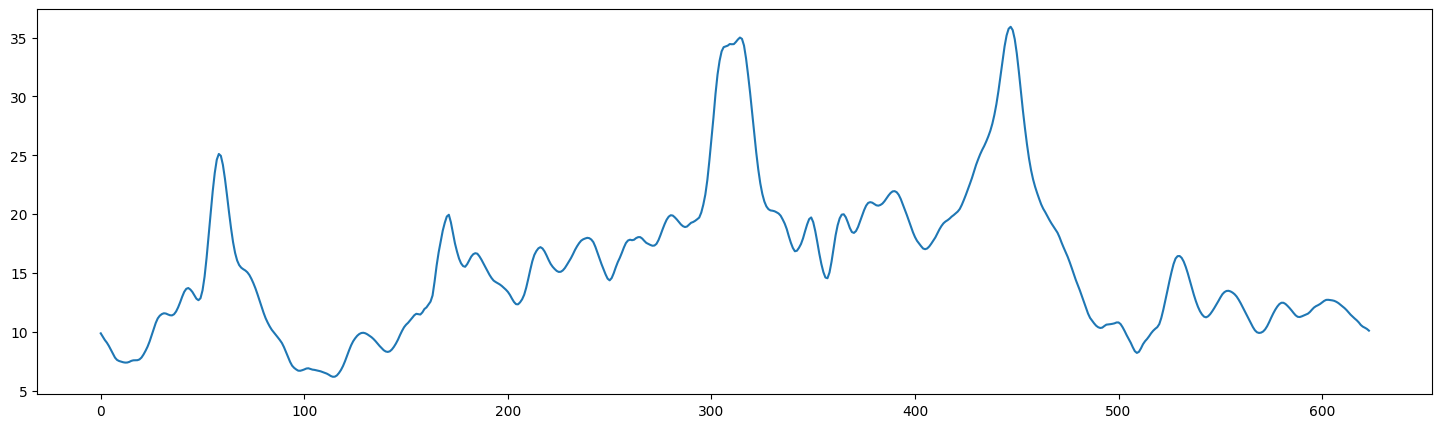

In [ ]:
plt.figure(100, figsize=(18, 5))
plt.plot(cA3_train)

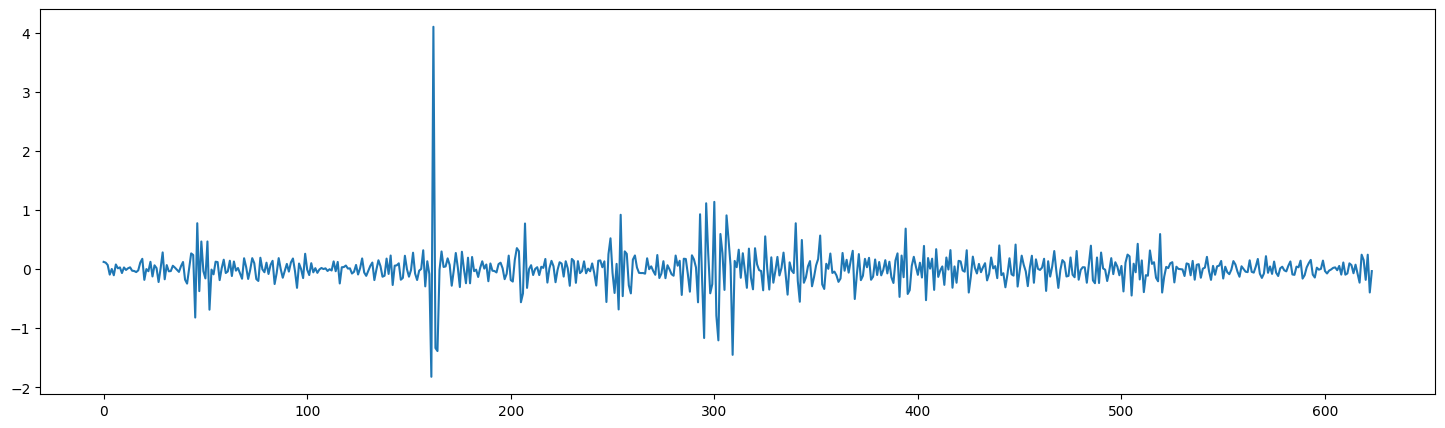

In [ ]:
plt.figure(100, figsize=(18, 5))
plt.plot(cD1_train)

##Wav-ARIMA

In [ ]:
"""Wav-ARIMA-N/A vs. Wav-ANN-N/A"""

###Wav-ARIMA-N/A

#Forecast cA3 with ARIMA (3,1,1)
arima_cA3_train_mod = sm.tsa.SARIMAX(cA3_train, order=(3,1,1))
arima_cA3_train_res = arima_cA3_train_mod.fit(maxiter=100)

arima_cA3 = sm.tsa.SARIMAX(cA3, order=(3,1,1))
arima_cA3_res = arima_cA3.filter(arima_cA3_train_res.params)

arima_cA3_preds = arima_cA3_res.predict(start=624, end=724)

#Reconstruct from forecasted coefficients
cA3_for_recon = cA3.copy()
cA3_for_recon[624:725] = arima_cA3_preds
cA3_recon = pywt.iswt([(cA3_for_recon, np.zeros((len(cD3),))), (np.zeros((len(cA2),)), np.zeros((len(cD2),))), (np.zeros((len(cA1),)), np.zeros((len(cD1),)))], 'db3')

#Evaluate
# MSE(cA3_recon[627:725], data_pad[627:725])
# MAPE(cA3_recon[627:725], data_pad[627:725])


##Wav-ANN

In [ ]:

###Wav-ANN-N/A

#Forecast cA3 with ANN: Time-lags = 3, Nodes = 4
cA3_preds, cA3_preds_unstd, cA3_MSE_std, cA3_RMSE_std, cA3_MSE, cA3_RMSE = NeuralNet_ts_predictions(cA3_train, cA3[624:725], num_lags=3, hidden_layer_sizes=(4, ), activation='relu', solver='lbfgs', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=2000, shuffle=True, random_state=42, tol=1e-10, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-10)

#Reconstruct from forecasted coefficients
cA3_for_recon_nn = cA3.copy()
cA3_for_recon_nn[627:725] = cA3_preds_unstd
cA3_recon_nn = pywt.iswt([(cA3_for_recon_nn, np.zeros((len(cA3_for_recon_nn),))), (np.zeros((len(cA2),)), np.zeros((len(cD2),))), (np.zeros((len(cA1),)), np.zeros((len(cD1),)))], 'db3')

# #Evaluate
# MSE(cA3_recon_nn[627:725], data_pad[627:725])
# MAPE(cA3_recon_nn[627:725], data_pad[627:725])

"""Comparison Plot"""
cA3_recon_df = pd.DataFrame(cA3_recon[627:725], index=data[627:725].index)
cA3_recon_nn_df = pd.DataFrame(cA3_recon_nn[627:725], index=data[627:725].index)



0.004003419327572068 0.06327257958683262 0.9959965806724279
0.010545962531014823 0.10269353694860657


Text(0, 0.5, 'Dollars per Million Btu')

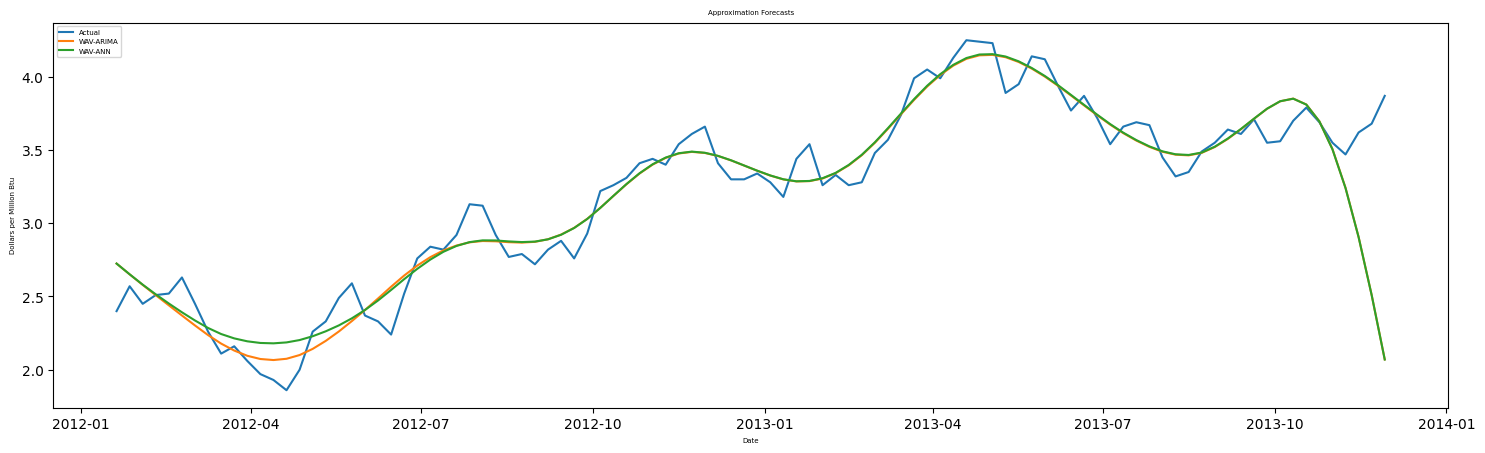

In [ ]:
plt.figure(100, figsize=(18, 5))
plt.plot(data[627:725], label='Actual')
plt.plot(cA3_recon_df, label='WAV-ARIMA')
plt.plot(cA3_recon_nn_df, label='WAV-ANN')
plt.legend(loc='upper left', prop={'size':5})
plt.title('Approximation Forecasts', fontsize=5)
plt.xlabel('Date', fontsize=5)
plt.ylabel('Dollars per Million Btu', fontsize=5)

In [ ]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 36.1 MB/s eta 0:00:00


##GARCH Forecasting Function

In [ ]:
"""GARCH Forecasting Function"""

"""
Properties of GARCH Models (written in LATEX)
r_t = \mu_t + \epsilon_t
\epsilon_t = \sigma_t * e_t
\sigma_t^2 = \omega + \sum_{i=1}^{q}\alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{p}\beta \sigma_{t-j}^2
where e_t ~ N(0,1) i.i.d., \epsilon_t ~ N(0, \sigma_t^2)
"""

def garch_forecast(data, index, split_date, p=1, q=1, forecast_length=1, horizon=1):

    import sys
    import numpy as np
    import pandas as pd
    import random
    from arch.univariate import arch_model


    #Model
    garch_mod = arch_model(data, vol='Garch', p=p, q=q)

    """Taken from examples in documentation"""

    #Recursive Forecast Generation
    data_df = pd.DataFrame(data, index=index)
    start_loc = 0
    end_loc = np.where(data_df.index >= split_date)[0].min()

    forecasts_mean = {}
    forecasts_variance = {}
    forecasts_residual_variance = {}

    for i in range(forecast_length):

        sys.stdout.write('.')
        sys.stdout.flush()

        #Fit the model
        res = garch_mod.fit(last_obs=i+end_loc-1, disp='off')

        #Create one-step forecasts for conditional mean, conditional variance, and conditional residual variance
        temp_mean = res.forecast(horizon=horizon).mean
        temp_variance = res.forecast(horizon=horizon).variance
        temp_residual_variance = res.forecast(horizon=horizon).residual_variance

        #Provide index of first most recent forecast
        fcast_mean = temp_mean.iloc[i+end_loc]
        fcast_variance = temp_variance.iloc[i+end_loc]
        fcast_residual_variance = temp_residual_variance.iloc[i+end_loc]

        #Fill in forecasts dictionaries initialized before for loop
        forecasts_mean[fcast_mean.name] = fcast_mean
        forecasts_variance[fcast_variance.name] = fcast_variance
        forecasts_residual_variance[fcast_residual_variance.name] = fcast_residual_variance

    #Convert forecast dictionariies to data frames
    forecasts_mean_df = pd.DataFrame(forecasts_mean).T
    forecasts_variance_df = pd.DataFrame(forecasts_variance).T
    forecasts_residual_variance_df = pd.DataFrame(forecasts_residual_variance).T

    #Forecast epsilon_t ~ N(0,sigma^2)
    forecasts_epsilon = np.zeros((len(forecasts_residual_variance_df),))
    for j in range(forecast_length):
        forecasts_epsilon[j:j+1] = np.random.normal(0, forecasts_residual_variance_df[j:j+1], 1)

    #GARCH forecasts
    preds = np.ravel(forecasts_mean_df) + forecasts_epsilon

    return preds

#Step_8

In [ ]:
"""
Detail Coefficient Models

GARCH Models
    -cD1: GARCH(3,3)
    -cD2: GARCH(1,2)
    -cD3: GARCH(1,2)

Models:
    -Wav-ARIMA-GARCH
    -Wav-ARIMA-ANN
    -Wav-ANN-GARCH
    -Wav-ANN-ANN
"""
# #GARCH forecasts of detail coefficients
# np.random.seed(42)
# cD1_preds = garch_forecast(cD1[:724], index=data[:724].index, split_date='2011-12-30', p=3, q=3, forecast_length=101, horizon=1)
# np.random.seed(42)
# cD2_preds = garch_forecast(cD2[:724], index=data[:724].index, split_date='2011-12-30', p=1, q=2, forecast_length=101, horizon=1)
# np.random.seed(42)
# cD3_preds = garch_forecast(cD3[:724], index=data[:724].index, split_date='2011-12-30', p=1, q=2, forecast_length=101, horizon=1)

#ANN forecasts of detail coefficients
cD1_nn_preds, cD1_nn_preds_unstd, cD1_MSE_std, cD1_RMSE_std, cD1_MSE, cD1_RMSE = NeuralNet_ts_predictions(cD1_train, cD1[624:725], num_lags=3, hidden_layer_sizes=(3,), activation='relu', solver='lbfgs', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=2000, shuffle=True, random_state=42, tol=1e-10, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-10)
cD2_nn_preds, cD2_nn_preds_unstd, cD2_MSE_std, cD2_RMSE_std, cD2_MSE, cD2_RMSE = NeuralNet_ts_predictions(cD2_train, cD2[624:725], num_lags=2, hidden_layer_sizes=(4,), activation='relu', solver='lbfgs', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=2000, shuffle=True, random_state=42, tol=1e-10, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-10)
cD3_nn_preds, cD3_nn_preds_unstd, cD3_MSE_std, cD3_RMSE_std, cD3_MSE, cD3_RMSE = NeuralNet_ts_predictions(cD3_train, cD3[624:725], num_lags=2, hidden_layer_sizes=(5,), activation='relu', solver='lbfgs', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=2000, shuffle=True, random_state=42, tol=1e-10, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-10)


#Prepare coefficient forecasts for wavelet reconstruction
cD1_for_recon = cD1.copy()
cD2_for_recon = cD2.copy()
cD3_for_recon = cD3.copy()

cD1_for_recon_nn = cD1.copy()
cD2_for_recon_nn = cD2.copy()
cD3_for_recon_nn = cD3.copy()

# cD1_for_recon[624:725] = cD1_preds
# cD2_for_recon[624:725] = cD2_preds
# cD3_for_recon[624:725] = cD3_preds

cD1_for_recon_nn[627:725] = cD1_nn_preds_unstd
cD2_for_recon_nn[626:725] = cD2_nn_preds_unstd
cD3_for_recon_nn[626:725] = cD3_nn_preds_unstd

###Wav-ARIMA-GARCH
wav_arima_garch_recon = pywt.iswt([(cA3_for_recon, cD3_for_recon), (np.zeros((len(cA2),)), cD2_for_recon), (np.zeros((len(cA1),)), cD1_for_recon)], 'db3')

#Evaluate
# MSE(wav_arima_garch_recon[627:725], data_pad[627:725])
# MAPE(wav_arima_garch_recon[627:725], data_pad[627:725])

###Wav-ANN-GARCH
wav_ann_garch_recon = pywt.iswt([(cA3_for_recon_nn, cD3_for_recon), (np.zeros((len(cA2),)), cD2_for_recon), (np.zeros((len(cA1),)), cD1_for_recon)], 'db3')

#Evaluate
# MSE(wav_ann_garch_recon[627:725], data_pad[627:725])
# MAPE(wav_ann_garch_recon[627:725], data_pad[627:725])

###Wav-ARIMA-ANN
wav_arima_ann_recon = pywt.iswt([(cA3_for_recon, cD3_for_recon_nn), (np.zeros((len(cA2),)), cD2_for_recon_nn), (np.zeros((len(cA1),)), cD1_for_recon_nn)], 'db3')

#Evaluate
# MSE(wav_arima_ann_recon[627:725], data_pad[627:725])
# MAPE(wav_arima_ann_recon[627:725], data_pad[627:725])

###Wav-ANN-ANN(cD3,cD2,cD1)
wav_ann_ann_recon = pywt.iswt([(cA3_for_recon_nn, cD3_for_recon_nn), (np.zeros((len(cA2),)), cD2_for_recon_nn), (np.zeros((len(cA1),)), cD1_for_recon_nn)], 'db3')

#Evaluate
# MSE(wav_ann_ann_recon[627:725], data_pad[627:725])
# MAPE(wav_ann_ann_recon[627:725], data_pad[627:725])

###Wav-ANN-ANN(cD3)
wav_ann_cD3nn = pywt.iswt([(cA3_for_recon_nn, cD3_for_recon_nn), (np.zeros((len(cA2),)), np.zeros((len(cA2),))), (np.zeros((len(cA1),)), np.zeros((len(cA1),)))], 'db3')

#Evaluate
# MSE(wav_ann_cD3nn[627:725], data_pad[627:725])
# MAPE(wav_ann_cD3nn[627:725], data_pad[627:725])

###Wav-ANN-ANN(cD3,cD2)
wav_ann_cD3cD2nn = pywt.iswt([(cA3_for_recon_nn, cD3_for_recon_nn), (np.zeros((len(cA2),)), cD2_for_recon_nn), (np.zeros((len(cA1),)), np.zeros((len(cA1),)))], 'db3')

#Evaluate
# MSE(wav_ann_cD3cD2nn[627:725], data_pad[627:725])
# MAPE(wav_ann_cD3cD2nn[627:725], data_pad[627:725])

###Wav-ANN-ANN(cD2)
wav_ann_cD2nn = pywt.iswt([(cA3_for_recon_nn, np.zeros((len(cA3),))), (np.zeros((len(cA2),)), cD2_for_recon_nn), (np.zeros((len(cA1),)), np.zeros((len(cA1),)))], 'db3')

#Evaluate
# MSE(wav_ann_cD2nn[627:725], data_pad[627:725])
# MAPE(wav_ann_cD2nn[627:725], data_pad[627:725])

###Wav-ANN-ANN(cD1)
wav_ann_cD1nn = pywt.iswt([(cA3_for_recon_nn, np.zeros((len(cA3),))), (np.zeros((len(cA2),)), np.zeros((len(cA2),))), (np.zeros((len(cA1),)), cD1_for_recon_nn)], 'db3')

#Evaluate
# MSE(wav_ann_cD1nn[627:725], data_pad[627:725])
# MAPE(wav_ann_cD1nn[627:725], data_pad[627:725])

###Wav-ANN-ANN(cD3,cD1)
wav_ann_cD3cD1nn = pywt.iswt([(cA3_for_recon_nn, cD3_for_recon_nn), (np.zeros((len(cA2),)), np.zeros((len(cA2),))), (np.zeros((len(cA1),)), cD1_for_recon_nn)], 'db3')

#Evaluate
# MSE(wav_ann_cD3cD1nn[627:725], data_pad[627:725])
# MAPE(wav_ann_cD3cD1nn[627:725], data_pad[627:725])

###Wav-ANN-ANN(cD2,cD1)
wav_ann_cD2cD1nn = pywt.iswt([(cA3_for_recon_nn, np.zeros((len(cD3),))), (np.zeros((len(cA2),)), cD2_for_recon_nn), (np.zeros((len(cA1),)), cD1_for_recon_nn)], 'db3')

#Evaluate
# MSE(wav_ann_cD2cD1nn[627:725], data_pad[627:725])
# MAPE(wav_ann_cD2cD1nn[627:725], data_pad[627:725])

"""Comparison Plots"""
wav_arima_garch_recon_df = pd.DataFrame(wav_arima_garch_recon[627:725], index=data[627:725].index)
wav_ann_garch_recon_df = pd.DataFrame(wav_ann_garch_recon[627:725], index=data[627:725].index)
wav_arima_ann_recon_df = pd.DataFrame(wav_arima_ann_recon[627:725], index=data[627:725].index)
wav_ann_ann_recon_df = pd.DataFrame(wav_ann_ann_recon[627:725], index=data[627:725].index)



0.6833108854121606 0.8266262065844274 0.3166891145878393
0.03659357723918065 0.1912944778062886
0.2597474628837008 0.5096542581826436 0.7402525371162991
0.03731954574724026 0.19318267455245633
0.03295858767633968 0.18154500179387942 0.9670414123236604
0.016264748314329 0.12753332236842652


Text(0, 0.5, 'Dollars per Million Btu')

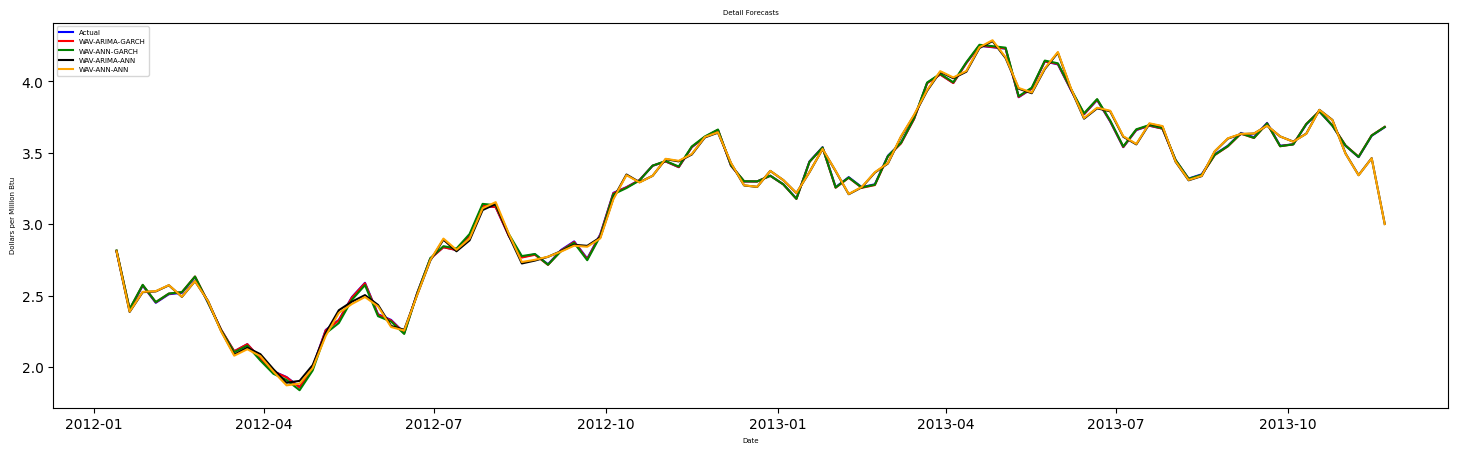

In [ ]:
plt.figure(100, figsize=(18, 5))
plt.plot(data[627:725], color='blue', label='Actual')
plt.plot(wav_arima_garch_recon_df, color='red', label='WAV-ARIMA-GARCH')
plt.plot(wav_ann_garch_recon_df, color='green', label='WAV-ANN-GARCH')
plt.plot(wav_arima_ann_recon_df, color='black', label='WAV-ARIMA-ANN')
plt.plot(wav_ann_ann_recon_df, color='orange', label='WAV-ANN-ANN')
plt.legend(loc='upper left', prop={'size':5})
plt.title('Detail Forecasts', fontsize=5)
plt.xlabel('Date', fontsize=5)
plt.ylabel('Dollars per Million Btu', fontsize=5)



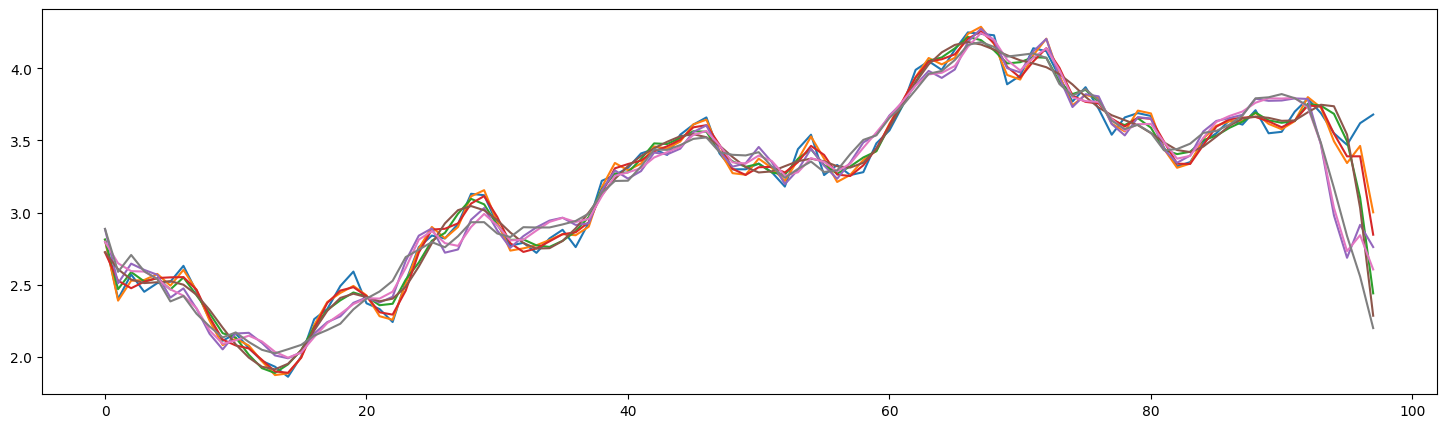

In [ ]:
plt.figure(100, figsize=(18, 5))
plt.plot(data_pad[627:725])
plt.plot(wav_ann_ann_recon[627:725])
plt.plot(wav_ann_cD3cD1nn[627:725])
plt.plot(wav_ann_cD3cD2nn[627:725])
plt.plot(wav_ann_cD2cD1nn[627:725])
plt.plot(wav_ann_cD3nn[627:725])
plt.plot(wav_ann_cD2nn[627:725])
plt.plot(wav_ann_cD1nn[627:725])